Run 1/5
Episode 10, Average Score: 10.00
Episode 20, Average Score: 13.50
Episode 30, Average Score: 10.40
Episode 40, Average Score: 11.80
Episode 50, Average Score: 25.00
Episode 60, Average Score: 31.80
Episode 70, Average Score: 47.00
Episode 80, Average Score: 14.70
Episode 90, Average Score: 11.60
Episode 100, Average Score: 55.80
Episode 110, Average Score: 60.50
Episode 120, Average Score: 38.50
Episode 130, Average Score: 30.50
Episode 140, Average Score: 45.60
Episode 150, Average Score: 64.30
Episode 160, Average Score: 199.80
Episode 170, Average Score: 134.60
Episode 180, Average Score: 166.40
Episode 190, Average Score: 124.70
Episode 200, Average Score: 136.10
Episode 210, Average Score: 112.00
Episode 220, Average Score: 60.60
Episode 230, Average Score: 154.60
Episode 240, Average Score: 219.80
Episode 250, Average Score: 187.30
Episode 260, Average Score: 397.20
Episode 270, Average Score: 416.10
Episode 280, Average Score: 296.50
Episode 290, Average Score: 181.90
Ep

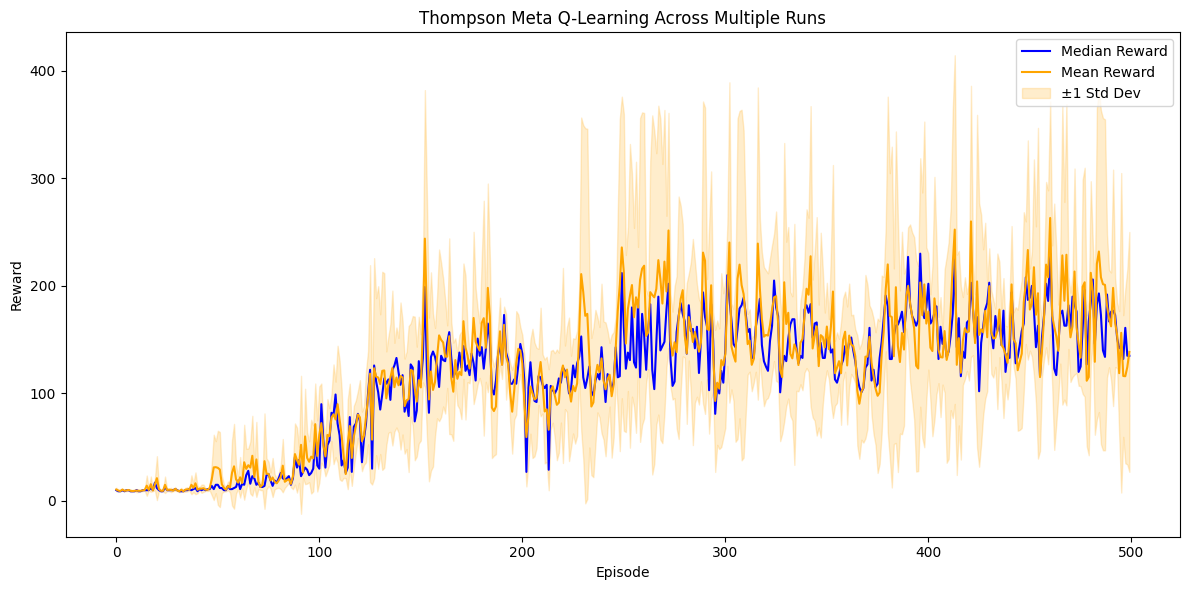

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from collections import deque, OrderedDict
import random
import optuna
import matplotlib.pyplot as plt


class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Outputs Q-values for each action


class MetaQPolicy:
    def __init__(self, policy):
        self.policy = policy
        self.params = OrderedDict(policy.named_parameters())

    def update_params(self, loss, step_size=0.1, first_order=False):
        grads = torch.autograd.grad(loss, self.params.values(), create_graph=not first_order)

        updated_params = OrderedDict()
        for (name, param), grad in zip(self.params.items(), grads):
            updated_params[name] = param - step_size * grad.clamp(-5, 5)  # Gradient clipping
        return updated_params

    def set_params(self, params):
        for name, param in self.policy.named_parameters():
            param.data = params[name].data.clone()

class ThompsonMetaQLearning:
    def __init__(self, state_dim, action_dim, hidden_dim=224, inner_lr=.0003590122649502572, meta_lr=0.009767756309404269,
                 memory_size=1000, batch_size=64, gamma=0.99, epsilon=0.1, thompson_alpha=1.5540433190233864, thompson_beta=0.9897499530825413):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.meta_policy = MetaQPolicy(self.q_network)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.meta_optimizer = optim.Adam(self.q_network.parameters(), lr=meta_lr)
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.inner_lr = inner_lr

        # Thompson sampling parameters
        self.alpha = np.ones(action_dim) * thompson_alpha
        self.beta = np.ones(action_dim) * thompson_beta

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        # Sample Thompson probabilities
        with torch.no_grad():
            q_values = self.q_network(state).cpu().numpy()[0]
        thompson_probs = np.array([np.random.beta(self.alpha[i], self.beta[i]) for i in range(len(q_values))])
        weighted_q_values = q_values * thompson_probs

        # Epsilon-greedy exploration
        if random.random() < self.epsilon:
            return random.randrange(len(q_values))
        return np.argmax(weighted_q_values)

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

        # Update Thompson sampling parameters
        if reward > 0:
            self.alpha[action] += 1
        else:
            self.beta[action] += 1

    def prepare_batch(self, batch):
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        return states, actions, rewards, next_states, dones

    def inner_loop_update(self, task_batch):
        states, actions, rewards, next_states, dones = self.prepare_batch(task_batch)

        # Compute Q-values
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * (1 - dones) * max_next_q_values

        # Compute loss
        loss = F.mse_loss(q_values, target_q_values)

        # Update parameters
        updated_params = self.meta_policy.update_params(loss, self.inner_lr)
        return updated_params

    def meta_update(self):
        if len(self.memory) < self.batch_size * 2:
            return

        self.meta_optimizer.zero_grad()
        meta_loss = 0

        # Meta-learning loop
        for _ in range(5):  # Use 5 tasks for meta-update
            task_start = random.randint(0, len(self.memory) - self.batch_size * 2)
            task_batch = list(self.memory)[task_start:task_start + self.batch_size]
            eval_batch = list(self.memory)[task_start + self.batch_size:task_start + self.batch_size * 2]

            updated_params = self.inner_loop_update(task_batch)

            # Temporarily set updated parameters for evaluation
            original_params = OrderedDict((name, param.clone()) for name, param in self.q_network.named_parameters())
            self.meta_policy.set_params(updated_params)

            # Evaluate on evaluation batch
            states, actions, rewards, next_states, dones = self.prepare_batch(eval_batch)
            q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
            with torch.no_grad():
                max_next_q_values = self.target_network(next_states).max(1)[0]
                target_q_values = rewards + self.gamma * (1 - dones) * max_next_q_values

            # Meta loss
            task_meta_loss = F.mse_loss(q_values, target_q_values)
            meta_loss += task_meta_loss

            # Revert to original parameters
            self.meta_policy.set_params(original_params)

        meta_loss = meta_loss / 5
        meta_loss.backward()
        self.meta_optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())


def train_thompson_meta_q(env_name='CartPole-v1', episodes=1000, max_steps=500):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonMetaQLearning(state_dim, action_dim)
    scores = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)
        agent.meta_update()

        # Update target network periodically
        if episode % 10 == 0:
            agent.update_target_network()

        # Decay epsilon
        agent.epsilon = max(0.1, agent.epsilon * 0.99)

        if (episode + 1) % 10 == 0:
            avg_score = np.mean(scores[-10:])
            print(f"Episode {episode + 1}, Average Score: {avg_score:.2f}")

    return agent, scores


def run_thompson_meta_q_multiple_times(env_name='CartPole-v1', runs=50, episodes=500, max_steps=500):
    all_scores = []
    all_losses = []  # Placeholder for loss tracking

    for run in range(runs):
        print(f"Run {run + 1}/{runs}")
        agent, scores = train_thompson_meta_q(env_name=env_name, episodes=episodes, max_steps=max_steps)
        all_scores.append(scores)
        # Placeholder: You can implement loss tracking in `train_thompson_meta_q` and collect here.
        # all_losses.append(losses)

    # Pad the scores to equal lengths with NaNs for aggregation
    max_len = max(len(scores) for scores in all_scores)
    padded_scores = np.array([np.pad(scores, (0, max_len - len(scores)), constant_values=np.nan) for scores in all_scores])

    # Compute statistics
    median_scores = np.nanmedian(padded_scores, axis=0)
    mean_scores = np.nanmean(padded_scores, axis=0)
    std_scores = np.nanstd(padded_scores, axis=0)

    return {
        'all_scores': all_scores,
        'median_scores': median_scores,
        'mean_scores': mean_scores,
        'std_scores': std_scores,
        'padded_scores': padded_scores
    }

if __name__ == "__main__":
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    stats = run_thompson_meta_q_multiple_times(runs=5, episodes=500)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))

    # Plot median and mean scores with confidence intervals
    x = np.arange(len(stats['median_scores']))
    plt.plot(stats['median_scores'], label='Median Reward', color='blue')
    plt.plot(stats['mean_scores'], label='Mean Reward', color='orange')
    plt.fill_between(x,
                     stats['mean_scores'] - stats['std_scores'],
                     stats['mean_scores'] + stats['std_scores'],
                     color='orange', alpha=0.2, label='±1 Std Dev')

    plt.title('Thompson Meta Q-Learning Across Multiple Runs')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import optuna
import matplotlib.pyplot as plt

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256, step=32)
    inner_lr = trial.suggest_loguniform("inner_lr", 1e-5, 1e-1)
    meta_lr = trial.suggest_loguniform("meta_lr", 1e-5, 1e-2)
    thompson_alpha = trial.suggest_uniform("thompson_alpha", 0.1, 2.0)
    thompson_beta = trial.suggest_uniform("thompson_beta", 0.1, 2.0)
    epsilon_decay = trial.suggest_uniform("epsilon_decay", 0.95, 0.999)
    batch_size = trial.suggest_int("batch_size", 8, 256, step=8)
    memory_size = trial.suggest_int("memory_size", 1000, 10000, step=100)
    gamma = trial.suggest_uniform("gamma", 0.9, 0.999)

    # Initialize environment and agent with sampled hyperparameters
    env_name = "CartPole-v1"
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonMetaQLearning(
        state_dim=state_dim,
        action_dim=action_dim,
        hidden_dim=hidden_dim,
        inner_lr=inner_lr,
        meta_lr=meta_lr,
        thompson_alpha=thompson_alpha,
        thompson_beta=thompson_beta,
        batch_size=batch_size,
        #memory_size=memory_size,
        gamma=gamma
    )

    episodes = 500
    max_steps = 500
    scores = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)
        agent.meta_update()

        # Update target network periodically
        if episode % 10 == 0:
            agent.update_target_network()

        # Decay epsilon
        agent.epsilon = max(0.1, agent.epsilon * epsilon_decay)

    # Objective: maximize the mean reward over the last 10 episodes
    return np.mean(scores[-10:])

# Run Optuna study
def optimize_hyperparameters():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study

if __name__ == "__main__":
    study = optimize_hyperparameters()

    # Plot optimization history
    optuna.visualization.plot_optimization_history(study)
    plt.title("Optimization History")
    plt.show()

    # Plot parameter importance
    optuna.visualization.plot_param_importances(study)
    plt.title("Parameter Importance")
    plt.show()

[I 2024-12-06 09:03:35,111] A new study created in memory with name: no-name-7fd91c07-45d9-43c3-8c20-3ee061952640
<ipython-input-15-20944992d631>:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-15-20944992d631>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-15-20944992d631>:10: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-15-20944992d631>:11: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r